## Analysis: compare fwdModel bwdText (fmbt) vs. noise ceiling

### Comparisons:
* fmbt: three GPT-2 forward-trained models evaluated on BrainBench (human*200) to get perplexities.
* noise ceiling: the same three models, each evaluated on BrainBench but shuffled input_ids using 10 shuffle seeds and get perplexities.

### Plotting:
* When comparing the two, noise ceiling has originally data shape (10, 200) where each row is 200 items' ppl given a shuffle seed. For plotting, we take the average over 10 seeds, arriving at 200 average ppls as noise ceiling.

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from utils import model_utils

/Users/ken/opt/miniconda3/envs/env_hf/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
shuffle_seeds = [121958, 182958, 201139, 377539, 393554, 422515, 500315, 532101, 889513, 898320]

In [35]:
llms = [
    "gpt2_scratch_neuro_tokenizer",
    "gpt2-medium_scratch_neuro_tokenizer",
    "gpt2-large_scratch_neuro_tokenizer",
]
type_of_abstract = "human_abstracts"

In [50]:
ymax = 0
# Get all models fmbt ppl correct results
x_models_ppl_correct_fmbt = {}
for llm in llms:
    # For each model, we get the fmbt ppl results
    results_dir = f"model_results/{llm.replace('/', '--')}_fwdModel_bwdText/{type_of_abstract}"
    model_ppl_correct_fmbt = []
    PPL_A_and_B = np.load(f"{results_dir}/PPL_A_and_B.npy")
    labels = np.load(f"{results_dir}/labels.npy")
    for i, label in enumerate(labels):
        model_ppl_correct_fmbt.append(PPL_A_and_B[i, label])
    if ymax < max(model_ppl_correct_fmbt):
        ymax = max(model_ppl_correct_fmbt)
    x_models_ppl_correct_fmbt[llm] = model_ppl_correct_fmbt

In [52]:
# Get all models ceiling ppl correct results
x_models_ppl_correct_x_ceiling = {}
for llm in llms:
    model_ppl_correct_x_shuffle_seeds = np.empty((len(shuffle_seeds), 200))
    for shuffle_seed in shuffle_seeds:
        results_dir = f"model_results/{llm.replace('/', '--')}_{shuffle_seed}/{type_of_abstract}"
        PPL_A_and_B = np.load(f"{results_dir}/PPL_A_and_B.npy")
        labels = np.load(f"{results_dir}/labels.npy")
        PPL_correct = np.empty(200)
        for i, label in enumerate(labels):
            PPL_correct[i] = PPL_A_and_B[i, label]
        model_ppl_correct_x_shuffle_seeds[shuffle_seeds.index(shuffle_seed)] = PPL_correct
        if ymax < max(PPL_correct):
            ymax = max(PPL_correct)
    model_ppl_correct_x_ceiling = model_ppl_correct_x_shuffle_seeds.mean(axis=0)
    x_models_ppl_correct_x_ceiling[llm] = model_ppl_correct_x_ceiling

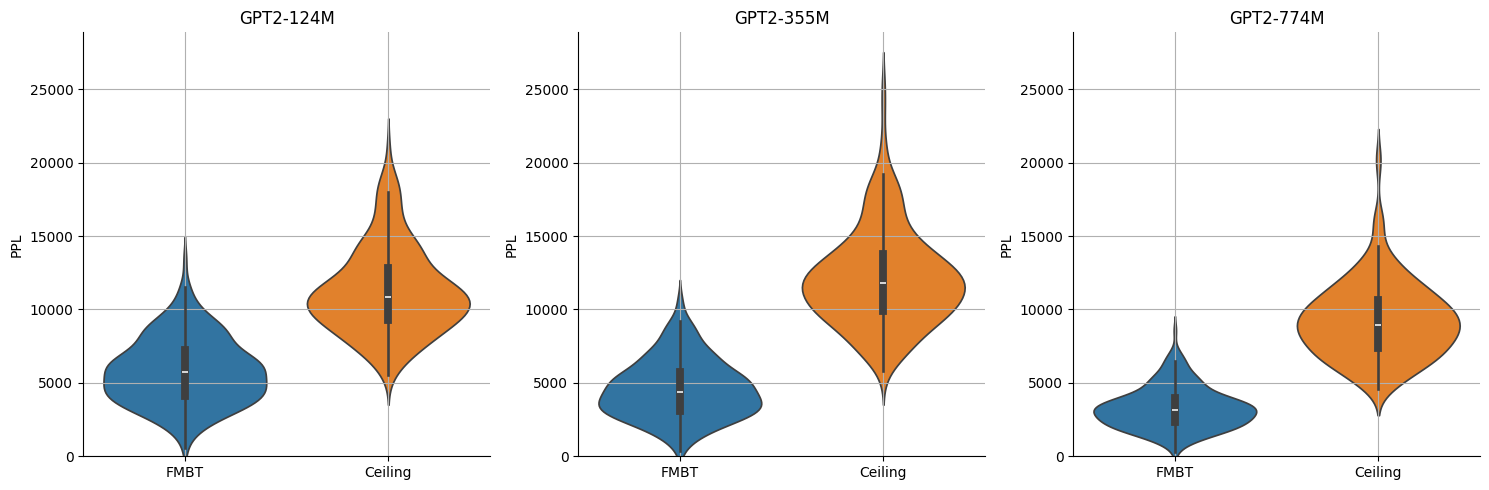

In [54]:
fig, axes = plt.subplots(1, len(llms), figsize=(5*len(llms), 5))
for i, llm in enumerate(llms):
    sns.violinplot(
        data=[x_models_ppl_correct_fmbt[llm], x_models_ppl_correct_x_ceiling[llm]],
        ax=axes[i]
    )
    if "medium" in llm:
        llm_family = "gpt2-medium"
    elif "large" in llm:
        llm_family = "gpt2-large"
    else:
        llm_family = "gpt2"
    llm_printname = model_utils.model_list[llm_family][llm]["llm"]
    axes[i].set_title(llm_printname)
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(["FMBT", "Ceiling"])
    axes[i].set_ylim([0, ymax])
    axes[i].set_ylabel("PPL")
    axes[i].grid(True)
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
plt.tight_layout()